# ETS Decomposition 

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [3]:
accident = pd.read_csv('motor-vehicle-fatalities-by-month.csv',index_col="YEAR_AND_MONTH")

In [4]:
accident.head()

,FATAL VICTIMS
YEAR_AND_MONTH,
1996-01-01,39
1996-02-01,32
1996-03-01,31
1996-04-01,36
1996-05-01,31


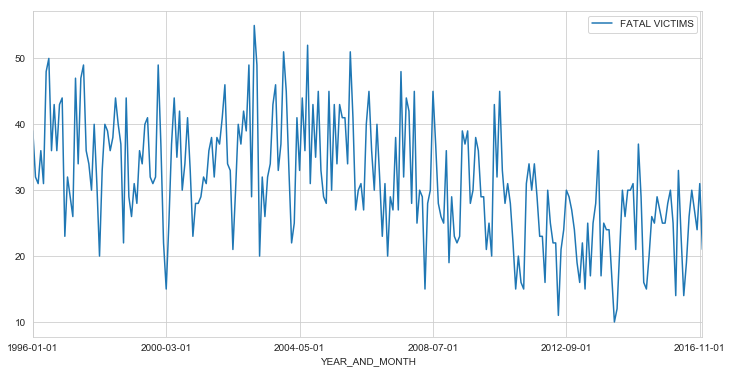

In [10]:
accident.plot(figsize=(12,6))

 - Based off this chart, it looks like the trend is fluctuating at a higher rate than just linear (it is hard to tell from this one plot).

In [13]:
accident.dropna(inplace=True)
accident.index = pd.to_datetime(accident.index)

In [14]:
accident.head()

,FATAL VICTIMS
YEAR_AND_MONTH,
1996-01-01,39
1996-02-01,32
1996-03-01,31
1996-04-01,36
1996-05-01,31


## ETS

To derieve a clear insight, We seperate the Error, Trend and Seasonality from the above chart.  

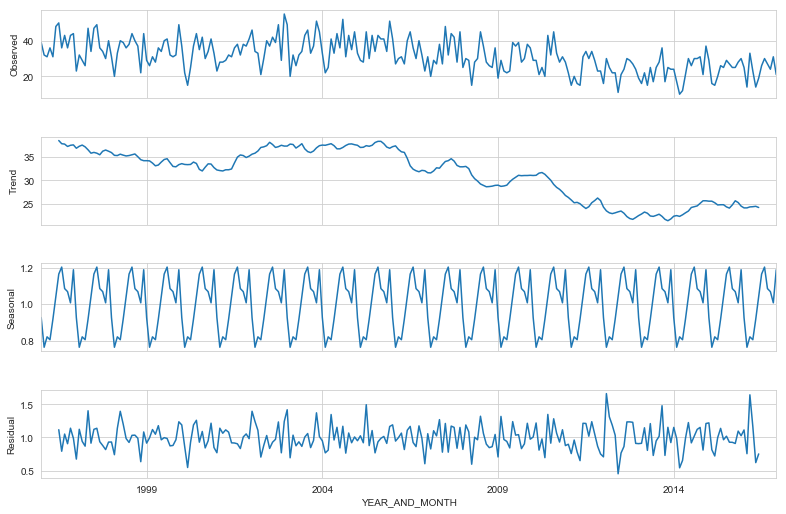

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(accident['FATAL VICTIMS'], model='multiplicative')
fig=result.plot()
fig.set_size_inches(12,8)

 - Now We see the Trend and seasonality clearly. The trend is decreasing, that is the number of fatal vitims are declining probably due to safe driving or cars are made much safer.

# ARIMA and Seasonal ARIMA
## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

**The Dataset**

Retrieved a dataset with seasonality from kaggle. The dataset contains Date and Quantity of Candies produced in USA from 1972(Jan) to 2018 (Dec).   

In [152]:
candy = pd.read_csv('candy_production.csv')

In [153]:
candy.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [154]:
candy = candy.rename(columns={'IPG3113N': 'Tonnes'})

In [156]:
candy.head()

,date,Tonnes
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [160]:
candy.set_index('date',inplace=True)

In [161]:
candy.head()

,Tonnes
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [162]:
candy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Tonnes,564.0,101.136666,18.131158,50.680157,88.344728,102.777853,114.928399,139.302096


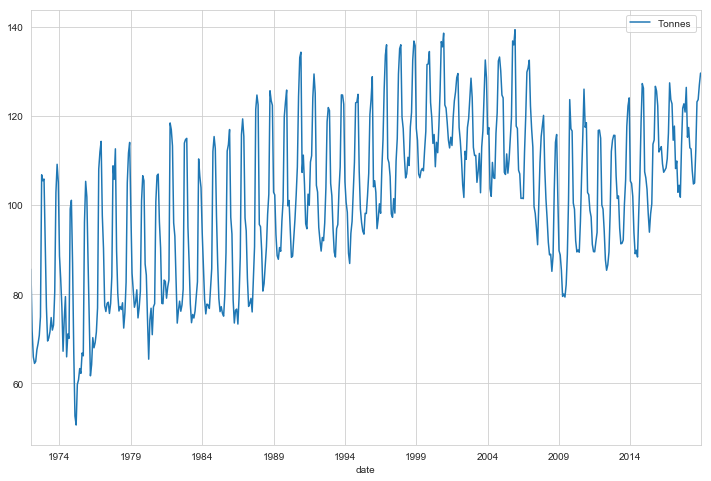

In [167]:
candy.plot(figsize= (12,8))

In [169]:
timeseries = candy['Tonnes']

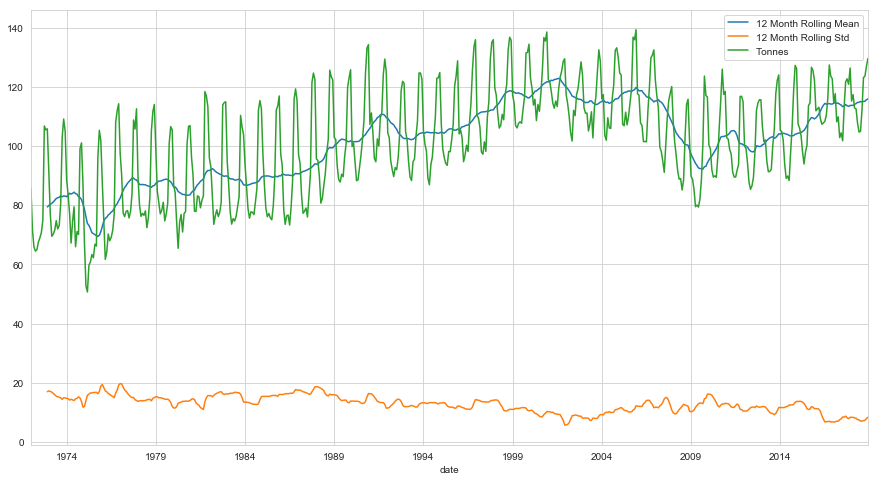

In [173]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot(figsize=(15,8))
plt.legend()


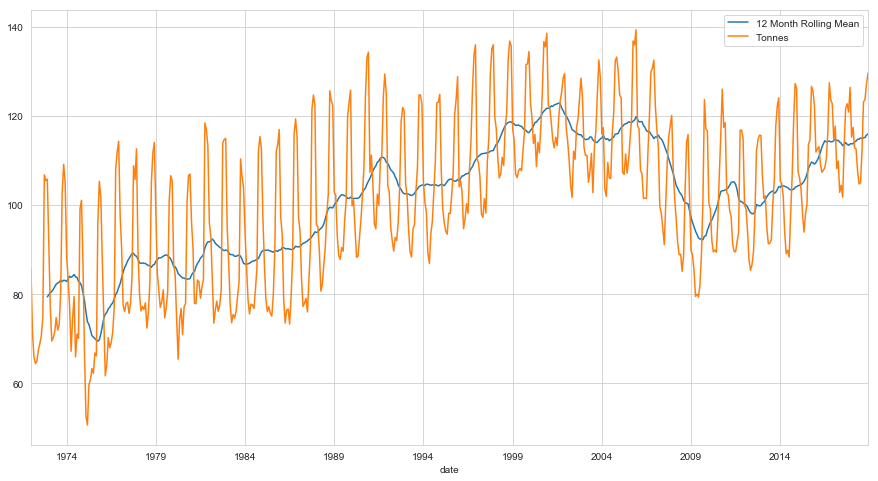

In [174]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot(figsize=(15,8))
plt.legend()

## Decomposition

ETS decomposition allows us to see the individual parts!

<Figure size 432x288 with 0 Axes>

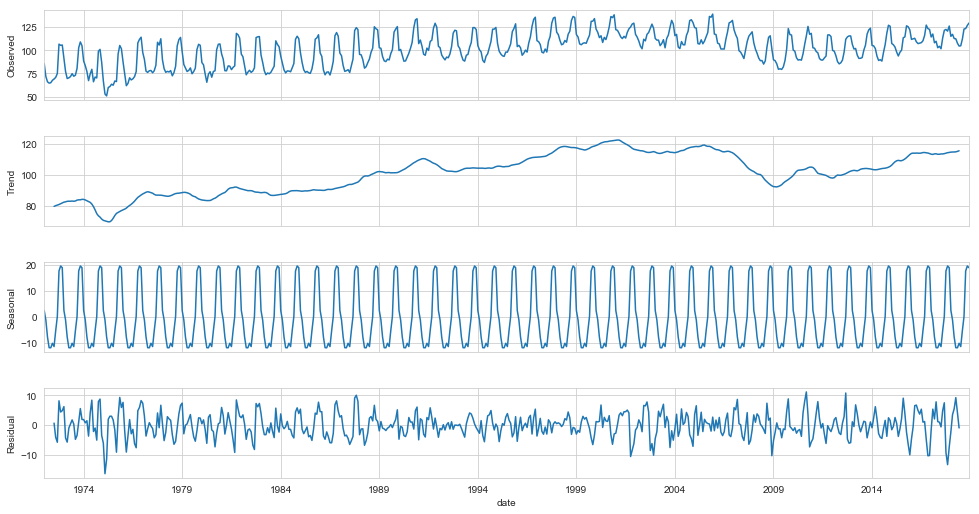

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(candy['Tonnes'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

We can use the **Augmented Dickey-Fuller.**

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

In [176]:
candy.head()

,Tonnes
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [177]:
from statsmodels.tsa.stattools import adfuller

In [178]:
result = adfuller(candy['Tonnes'])

In [180]:
# Creating a function for later use!
def adf_check(time_series):
    
    ######
    ######
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis,reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [181]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7760153075016125
p-value : 0.3924327500713993
#Lags Used : 14
Number of Observations Used : 549
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data.**

## Differencing

The first difference of a time series is the series of changes from one period to the next. We do this with pandas. We can continue to take the second difference, third difference, and so on until the data is stationary.

In [182]:
candy['Tonnes First Difference'] = candy['Tonnes'] - candy['Tonnes'].shift(1)

In [185]:
adf_check(candy['Tonnes First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.175912489755648
p-value : 6.631549159335912e-08
#Lags Used : 13
Number of Observations Used : 549
strong evidence against the null hypothesis,reject the null hypothesis. Data has no unit root and is stationary


**Note : Our Data has become stationary, So we dont need to do the second differenceing.** 

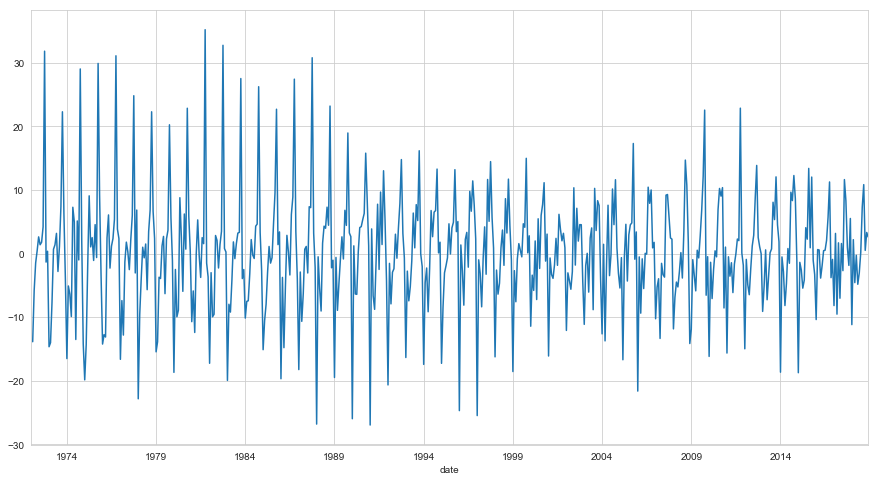

In [188]:
candy['Tonnes First Difference'].plot(figsize=(15,8))

In [189]:
candy['Tonnes Second Difference'] = candy['Tonnes First Difference'] - candy['Tonnes First Difference'].shift(1) 

In [190]:
adf_check(candy['Tonnes Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.933291228076412
p-value : 3.4667492920885748e-12
#Lags Used : 19
Number of Observations Used : 542
strong evidence against the null hypothesis,reject the null hypothesis. Data has no unit root and is stationary


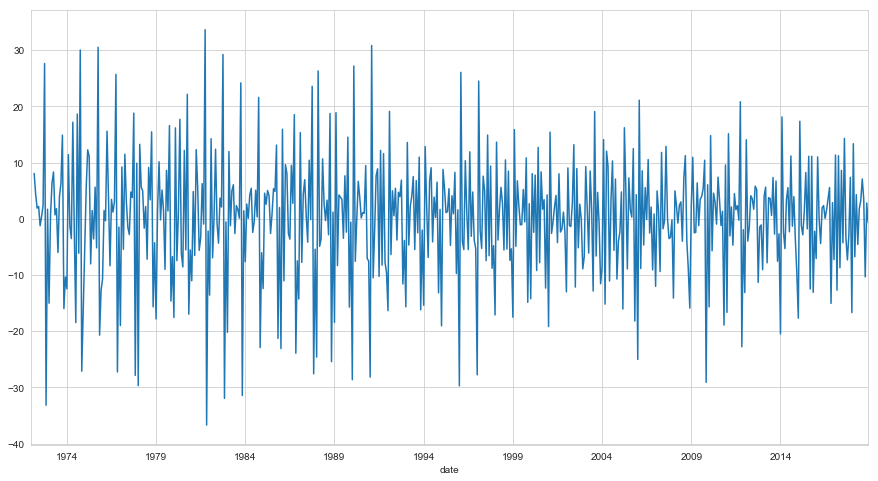

In [192]:
candy['Tonnes Second Difference'].plot(figsize=(15,8))

**Note the difference in the plot from both the steps of differencing.**

### As we have a seasonal data, We proceed to Seasonal Difference

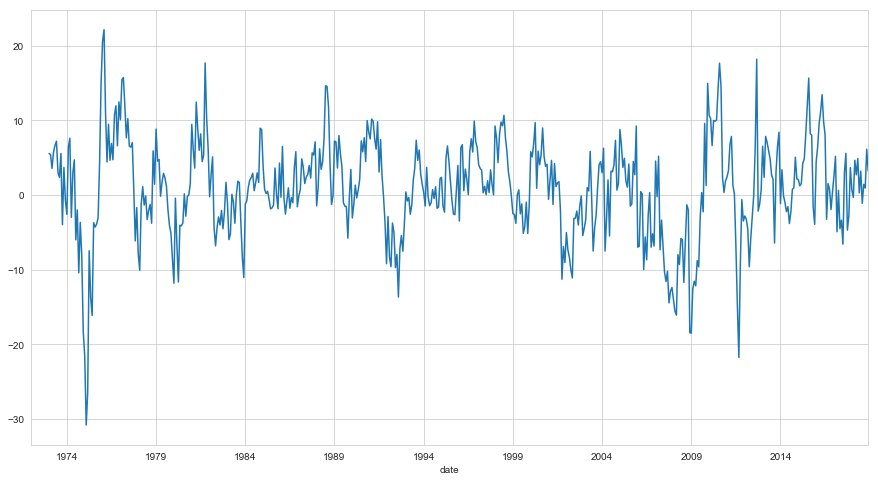

In [196]:
candy['Seasonal Difference'] = candy['Tonnes'] - candy['Tonnes'].shift(12)
candy['Seasonal Difference'].plot(figsize=(15,8))

In [198]:
adf_check(candy['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.632800674231291
p-value : 1.0798466263498726e-06
#Lags Used : 18
Number of Observations Used : 533
strong evidence against the null hypothesis,reject the null hypothesis. Data has no unit root and is stationary


**Seasonal First Difference**

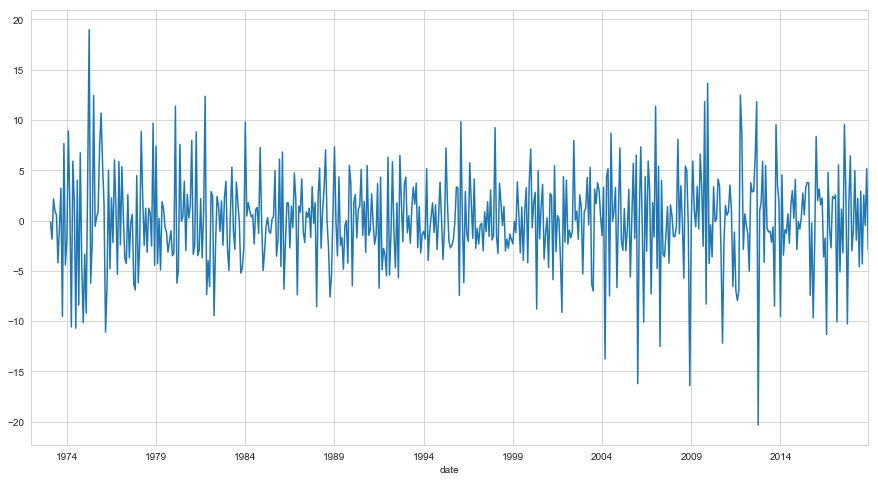

In [203]:
candy['Seasonal First Difference'] = candy['Tonnes First Difference'] - candy['Tonnes First Difference'].shift(12)
candy['Seasonal First Difference'].plot(figsize=(15,8))

In [202]:
adf_check(candy['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.781629311557391
p-value : 8.387343113455546e-12
#Lags Used : 18
Number of Observations Used : 532
strong evidence against the null hypothesis,reject the null hypothesis. Data has no unit root and is stationary


# Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a Correlogram) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models is a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general we would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

**Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically we would just choose a single stationary data set and continue all the way through with that.**

**The reason we use two here is to show the two typical types of behaviour we would see when using ACF.**

In [204]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

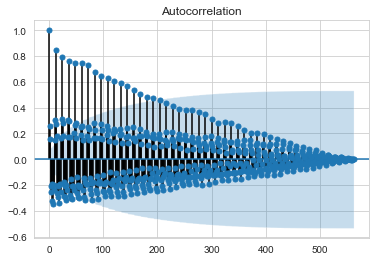

In [221]:
fig_first = plot_acf(candy["Tonnes First Difference"].dropna())

<Figure size 864x576 with 0 Axes>

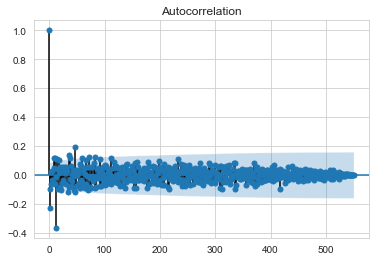

<Figure size 864x576 with 0 Axes>

In [228]:
fig = plt.figure(figsize=(12,8))
fig = plot_acf(candy["Seasonal First Difference"].dropna())

Pandas also has this functionality built in, but only for ACF, not PACF. So its best using statsmodels, as ACF and PACF is more core to its functionality than in pandas.

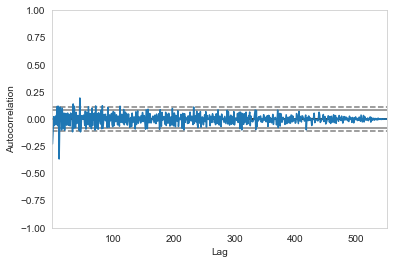

In [223]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(candy['Seasonal First Difference'].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables. 

/Users/kirandarshak/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


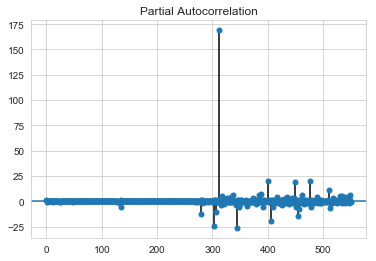

In [224]:
result = plot_pacf(candy["Seasonal First Difference"].dropna())

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

### ACF and PACF Plots

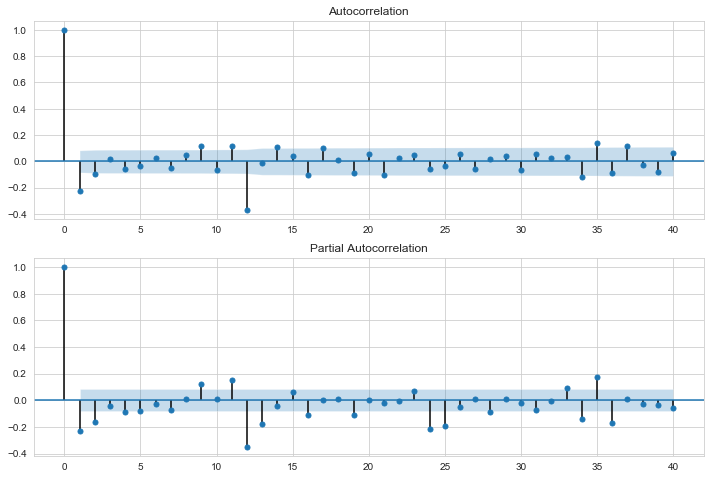

In [229]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(candy['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(candy['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## Using the Seasonal ARIMA model

In [230]:
from statsmodels.tsa.arima_model import ARIMA

In [231]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes


### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [232]:
model = sm.tsa.statespace.SARIMAX(candy['Tonnes'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/Users/kirandarshak/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kirandarshak/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                                 Statespace Model Results                                 
Dep. Variable:                             Tonnes   No. Observations:                  564
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1542.898
Date:                            Wed, 25 Sep 2019   AIC                           3091.797
Time:                                    02:44:24   BIC                           3104.732
Sample:                                01-01-1972   HQIC                          3096.851
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1824      0.053      3.453      0.001       0.079       0.286
ma.S.L12      -0.8073      0.035   

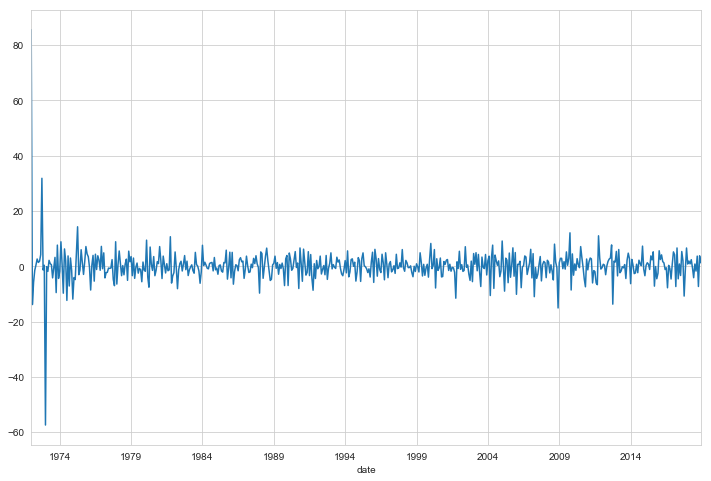

In [234]:
results.resid.plot(figsize=(12,8))

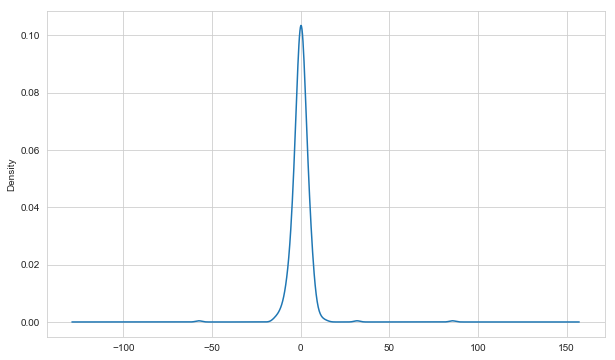

In [235]:
results.resid.plot(kind='kde',figsize=(10,6))

## Predicting Future Values

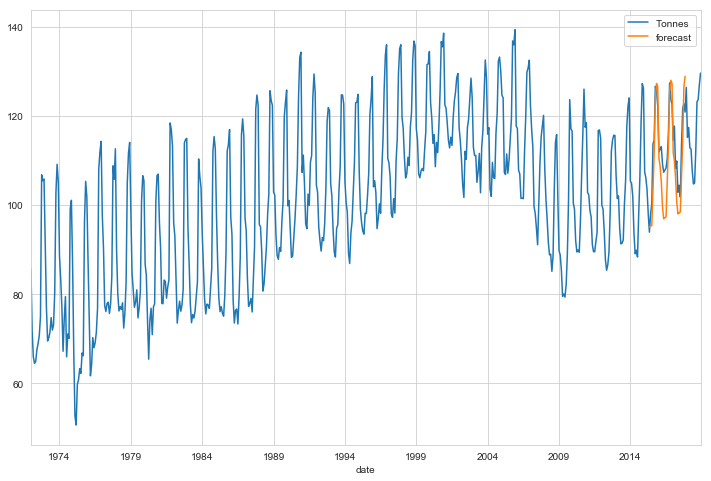

In [281]:
candy['forecast'] = results.predict(start = 520, end=550, dynamic= True)  
candy[['Tonnes','forecast']].plot(figsize=(12,8))

In [282]:
candy.tail()

,Tonnes,Tonnes First Difference,Tonnes Second Difference,Seasonal Difference,Seasonal First Difference,forecast
date,,,,,,
2018-08-01,112.279777,7.329277,7.092987,-1.110841,-4.310241,NaN
2018-09-01,123.126335,10.846558,3.517282,1.425628,2.536470,NaN
2018-10-01,123.634268,0.507933,-10.338625,0.941164,-0.484464,NaN
2018-11-01,126.960101,3.325833,2.817900,6.121363,5.180198,NaN
2018-12-01,129.571073,2.610972,-0.714861,3.208188,-2.913175,NaN


In [283]:
from pandas.tseries.offsets import DateOffset

In [292]:
future_dates = [candy.index[-1] + DateOffset(months=x) for x in range(1,24) ]

In [293]:
future_dates

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00')]

In [294]:
future_dates_candy = pd.DataFrame(index=future_dates[1:],columns=candy.columns)

In [295]:
future_candy = pd.concat([candy,future_dates_candy])

In [308]:
future_candy.head()

,Tonnes,Tonnes First Difference,Tonnes Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1972-01-01,85.598809,NaN,NaN,NaN,NaN,NaN
1972-02-01,71.741404,-13.857405,NaN,NaN,NaN,NaN
1972-03-01,65.948809,-5.792594,8.064811,NaN,NaN,NaN
1972-04-01,64.490724,-1.458086,4.334509,NaN,NaN,NaN
1972-05-01,64.933842,0.443118,1.901204,NaN,NaN,NaN


In [297]:
future_candy.tail()

,Tonnes,Tonnes First Difference,Tonnes Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN


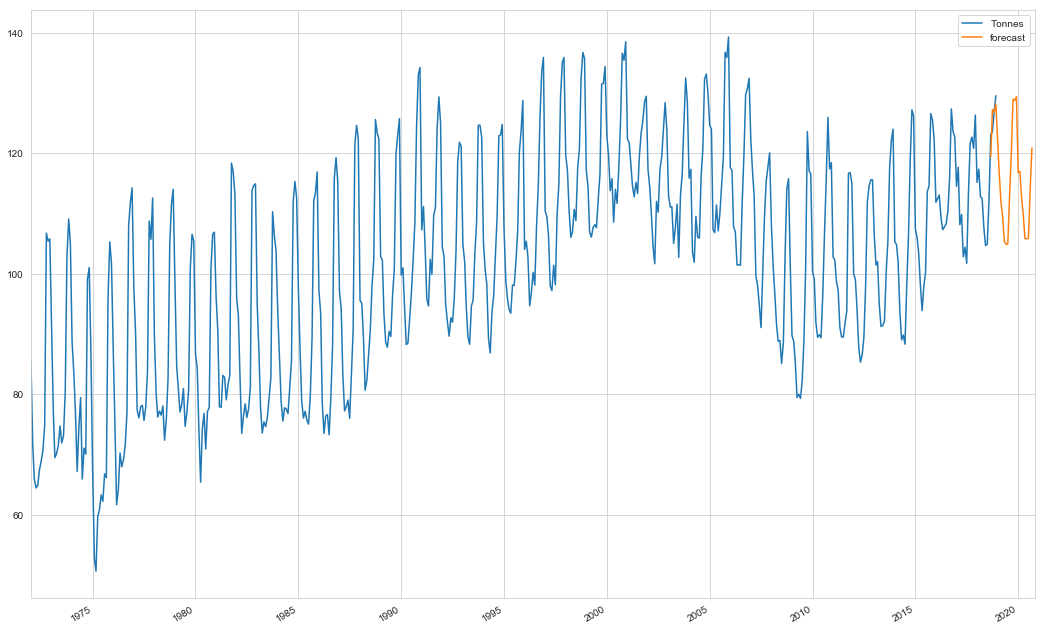

In [306]:
future_candy['forecast'] = results.predict(start = 560, end = 584, dynamic= True)  
future_candy[['Tonnes', 'forecast']].plot(figsize=(18, 12)) 

**Our Prediction seems appealing and convincing. As we have our residuals(errors) close to zero from the kde plot, the prediction appear to be true.**

In [307]:
future_candy.tail()

,Tonnes,Tonnes First Difference,Tonnes Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2020-07-01,NaN,NaN,NaN,NaN,NaN,105.918907
2020-08-01,NaN,NaN,NaN,NaN,NaN,113.983384
2020-09-01,NaN,NaN,NaN,NaN,NaN,120.905722
2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN
